# Extreme Conditions Modeling - Full Sea State Approach
Extreme conditions modeling consists of identifying the expected extreme (e.g. 100-year) response of some quantity of interest, such as WEC motions or mooring loads. 
Three different methods of estimating extreme conditions were adapted from [WDRT](https://github.com/WEC-Sim/WDRT): full sea state approach, contour approach, and MLER design wave. 
This noteboook presents the full sea state approach. 

The full sea state approach consists of the following steps: 
1. Take $N$ samples to represent the sea state. Each sample represents a small area of the sea state and consists of a representative $(H_{s}, T_{e})_i$ pair and a weight $W_i$ associated with the probability of that sea state area. 
2. For each sample $(H_{s}, T_{e})_i$ calculate the short-term (e.g. 3-hours) extreme for the quantity of interest (e.g. WEC motions or mooring tension).
3. Integrate over the entire sea state to obtain the long-term extreme. This is a sum of the products of the weight of each sea state times the short-term extreme. 

See more details and equations in

> [1] Coe, Ryan G., Carlos A. Michelén Ströfer, Aubrey Eckert-Gallup, and Cédric Sallaberry. 2018. “Full Long-Term Design Response Analysis of a Wave Energy Converter.” Renewable Energy 116: 356–66.

**NOTE:** Prior to running this example it is recommended to become familiar with `environmental_contours_example.ipynb` and `short_term_extremes_example.ipynb` since some code blocks are adapted from those examples and used here without the additional description. 

We start by importing the relevant modules, including `waves.contours` submodule which includes the sampling function, and `loads.extreme` which inlcudes the short-term extreme and full sea state integration functions. 

In [1]:
from mhkit.wave import resource, contours, graphics
from mhkit.loads import extreme
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
import pandas as pd
import numpy as np

## Obtain and Process NDBC Buouy Data
The first step will be obtaining the environmental data and creating the contours.
See `environmental_contours_example.ipynb` for more details and explanations of how this is being done in the following code block. 

In [2]:
parameter = 'swden'
buoy_number = '46022'
ndbc_available_data = ndbc.available_data(parameter, buoy_number)

years_of_interest = ndbc_available_data[ndbc_available_data.year < 2013]

filenames = years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)

ndbc_data = {}
for year in ndbc_requested_data:
    year_data = ndbc_requested_data[year]
    ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

Hm0_list = []
Te_list = []

# Iterate over each year and save the result in the initalized dictionary
for year in ndbc_data:
    year_data = ndbc_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Te = pd.concat(Te_list, axis=0)
Hm0 = pd.concat(Hm0_list, axis=0)
Hm0_Te = pd.concat([Hm0, Te], axis=1)

# Drop any NaNs created from the calculation of Hm0 or Te
Hm0_Te.dropna(inplace=True)
# Sort the DateTime index
Hm0_Te.sort_index(inplace=True)

Hm0_Te_clean = Hm0_Te[Hm0_Te.Hm0 < 20]

Hm0 = Hm0_Te_clean.Hm0.values
Te = Hm0_Te_clean.Te.values

dt = (Hm0_Te_clean.index[2]-Hm0_Te_clean.index[1]).seconds

## 1. Sampling
The first step is sampling the sea state to get samples $(H_s, T_e)_i$ and associtated weights. 
For this we will use the `waves.contours.samples_full_seastate` function. 
We will sample 20 points between each return level, for 10 levels ranging from 0.001—100 years return periods. 
For more details on the sampling approach see

> [1] Coe, Ryan G., Carlos A. Michelén Ströfer, Aubrey Eckert-Gallup, and Cédric Sallaberry. 2018. “Full Long-Term Design Response Analysis of a Wave Energy Converter.” Renewable Energy 116: 356–66.

> [2] Eckert-Gallup, Aubrey C., Cédric J. Sallaberry, Ann R. Dallman, and Vincent S. Neary. 2016. “Application of Principal Component Analysis (PCA) and Improved Joint Probability Distributions to the Inverse First-Order Reliability Method (I-FORM) for Predicting Extreme Sea States.” Ocean Engineering 112 (January): 307–19.

In [3]:
# return levels
levels = np.array([0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100])

# points per return level interval
npoints = 20

# Create samples
sample_hs, sample_te, sample_weights = contours.samples_full_seastate(
    Hm0, Te, npoints, levels, dt)

We will now plot the samples alongside the contours. 
First we will create the different contours using `contours.environmental_contours`. 
See `environmental_contours_example.ipynb` for more details on using this function. 
There are 20 samples, randomly distributed, between each set of return levels. 

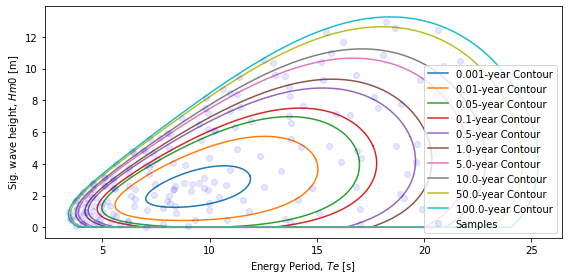

In [4]:
# Create the contours
Te_contours = []
Hm0_contours = []

for period in levels:
    copula = contours.environmental_contours(
        Hm0, Te, dt, period, 'PCA', return_PCA=True)
    Hm0_contours.append(copula['PCA_x1'])
    Te_contours.append(copula['PCA_x2'])

# plot
fig, ax = plt.subplots(figsize=(8, 4))

labels = [f"{period}-year Contour" for period in levels]

ax = graphics.plot_environmental_contour(
    sample_te, sample_hs, Te_contours, Hm0_contours,
    data_label='Samples', contour_label=labels,
    x_label='Energy Period, $Te$ [s]',
    y_label='Sig. wave height, $Hm0$ [m]', ax=ax)


## 2. Short-Term Extreme Distributions
Many different methods for short-term extremes were adapted from WDRT, and a summary and examples can be found in `short_term_extremes_example.ipynb`. 
The response quantity of interest is typically related to the WEC itself, e.g. maximum heave displacement, PTO extension, or load on the mooring lines. 
This requires running a simulation (e.g. WEC-Sim) for each of the 200 sampled sea states $(H_s, T_e)_i$. 
For the sake of example we will consider the wave elevation as the quantity of interest (can be thought as a proxy for heave motion in this example). 
Wave elevation time-series for a specific sea state can be created quickly without running any external software. 

**NOTE:** The majority of the for loop below is simply creating the synthetic data (wave elevation time series). In a realistic case the variables `time` and `data` describing each time series would be obtained externally, e.g. through simulation software such as WEC-Sim or CFD. For this reason the details of creating the synthetic data are not presented here, instead assume for each sea state there is time-series data available. 

The last lines of the for-loop create the short-term extreme distribution from the time-series using the `loads.extreme.short_term_extreme` function. The short-term period will be 3-hours and we will use 1-hour "simulations" and the Weibul-tail-fitting method to estimate the 3-hour short-term extreme distributions for each of the 200 samples.

For more details on short-term extreme distributions see `short_term_extremes_example.ipynb` and 

> [3] Michelén Ströfer, Carlos A., and Ryan Coe. 2015. “Comparison of Methods for Estimating Short-Term Extreme Response of Wave Energy Converters.” In OCEANS 2015 - MTS/IEEE Washington, 1–6. IEEE.

In [5]:
# create the short-term extreme distribution for each sample sea state
t_st = 3.0 * 60.0 * 60.0
gamma = 3.3 
t_sim = 1.0 * 60.0 * 60.0

ste_all = []
i = 0
n = len(sample_hs)
for hs, te in zip(sample_hs, sample_te):
    tp = te / (0.8255 + 0.03852*gamma - 0.005537*gamma**2 + 0.0003154*gamma**3)
    i += 1
    print(f"Sea state {i}/{n}. (Hs, Te) = ({hs} m, {te} s). Tp = {tp} s")
    # time & frequency arrays
    df = 1.0/t_sim
    T_min = tp/10.0  # s
    f_max = 1.0/T_min
    Nf = int(f_max/df) + 1
    time = np.linspace(0, t_sim, 2*Nf+1)
    f = np.linspace(0.0, f_max, Nf)
    # spectrum
    S = resource.jonswap_spectrum(f, tp, hs, gamma)
    # 1-hour elevation time-series
    data = resource.surface_elevation(S, time).values.squeeze()
    # 3-hour extreme distribution
    ste = extreme.short_term_extreme(time, data, t_st, 'peaks_weibull_tail_fit')
    ste_all.append(ste)

Sea state 1/200. (Hs, Te) = (2.851166377141435 m, 10.195736685047796 s). Tp = 11.282805679200564 s
Sea state 2/200. (Hs, Te) = (3.5862460438066304 m, 10.936985799409186 s). Tp = 12.103086741331571 s
Sea state 3/200. (Hs, Te) = (2.7751615384993915 m, 9.506986218875468 s). Tp = 10.520620668805236 s
Sea state 4/200. (Hs, Te) = (3.0820450802745007 m, 9.728717644182273 s). Tp = 10.765993088865644 s
Sea state 5/200. (Hs, Te) = (2.7162732683836195 m, 9.177186568411022 s). Tp = 10.155657794203384 s
Sea state 6/200. (Hs, Te) = (2.7916623630702304 m, 8.810734371427328 s). Tp = 9.75013448019444 s
Sea state 7/200. (Hs, Te) = (2.592821066032464 m, 8.374599835754573 s). Tp = 9.267499299629163 s
Sea state 8/200. (Hs, Te) = (2.4021986215575373 m, 8.348365892255037 s). Tp = 9.238468294234675 s
Sea state 9/200. (Hs, Te) = (2.327723379324664 m, 8.299620704291481 s). Tp = 9.184525896487639 s
Sea state 10/200. (Hs, Te) = (2.00764351315584 m, 7.416472871792525 s). Tp = 8.207216881170892 s
Sea state 11/200. 

Sea state 84/200. (Hs, Te) = (5.125297529462439 m, 18.672283211728097 s). Tp = 20.66312122143036 s
Sea state 85/200. (Hs, Te) = (7.5395641905378215 m, 17.827501744997704 s). Tp = 19.728269192102534 s
Sea state 86/200. (Hs, Te) = (7.077565789406247 m, 16.565463530565825 s). Tp = 18.331672519098774 s
Sea state 87/200. (Hs, Te) = (7.660797463748704 m, 14.340144866170789 s). Tp = 15.86909047718626 s
Sea state 88/200. (Hs, Te) = (8.267146386057341 m, 13.752524476289345 s). Tp = 15.218818027340491 s
Sea state 89/200. (Hs, Te) = (7.5585377867557515 m, 11.41873618959678 s). Tp = 12.636201336801353 s
Sea state 90/200. (Hs, Te) = (6.189724705513505 m, 9.943266929556025 s). Tp = 11.003417609551178 s
Sea state 91/200. (Hs, Te) = (4.985820233723228 m, 8.101640035422118 s). Tp = 8.965436537464955 s
Sea state 92/200. (Hs, Te) = (3.950449104550366 m, 7.032331054963992 s). Tp = 7.7821178808320965 s
Sea state 93/200. (Hs, Te) = (3.349526273174492 m, 6.2239567755115734 s). Tp = 6.887554771478645 s
Sea st

Sea state 167/200. (Hs, Te) = (11.673289407430126 m, 16.196134650574198 s). Tp = 17.9229658102669 s
Sea state 168/200. (Hs, Te) = (10.377818028562164 m, 12.9398233046888 s). Tp = 14.319466692789565 s
Sea state 169/200. (Hs, Te) = (8.744961663025443 m, 10.648293741704611 s). Tp = 11.783614349210453 s
Sea state 170/200. (Hs, Te) = (6.859939603914331 m, 8.737652031185462 s). Tp = 9.669260104070206 s
Sea state 171/200. (Hs, Te) = (5.960600437241585 m, 8.015473102288261 s). Tp = 8.87008248973364 s
Sea state 172/200. (Hs, Te) = (4.693969291807187 m, 6.476150181500641 s). Tp = 7.166637027253579 s
Sea state 173/200. (Hs, Te) = (3.1828656644648836 m, 5.082363302518114 s). Tp = 5.624244652915248 s
Sea state 174/200. (Hs, Te) = (2.7310116880872317 m, 4.561878698618447 s). Tp = 5.048266003581575 s
Sea state 175/200. (Hs, Te) = (1.960761965106161 m, 3.9966122086956775 s). Tp = 4.422730825518815 s
Sea state 176/200. (Hs, Te) = (1.745663077932535 m, 3.8392198892428673 s). Tp = 4.248557343931261 s
Sea

## 3. Long-Term Extreme Distribution
Finally we integrate the weighted short-term extreme distributions over the entire sea state space to obtain the extreme distribution, assuming a 3-hour sea state coherence. 
For this we use the `loads.extreme.full_seastate_long_term_extreme` function.
The integral reduces to a sum over the 200 bins of the weighted short-term extreme distributions.  

In [6]:
lte = extreme.full_seastate_long_term_extreme(ste_all, sample_weights)

Similar to the short-term extreme functions, the output of long-term extreme function is a probability distribution (`scipy.stats.rv_continuous`). 
This object provides common statistical functions (PDF, CDF, PPF, etc.) and metrics (expected value, median, etc). 
Here, we will look at the survival function and the 100-year return level. 

The value of the survival function at a given return level (e.g. 100-years) 
may be calculated using the `return_year_value` function. This gives a 100-year wave of about 11.1 meters.  

In [7]:
t_st_hr = t_st/(60.0*60.0)
t_return_yr = 100.0
x_t = extreme.return_year_value(lte.ppf, t_return_yr, t_st_hr)

print(f"100-year elevation: {x_t} m")

100-year elevation: 10.949955788933982 m


Finally we plot the survival function and show the 100-year return level (dashed grey lines). The 100-year value is about 11.1 m (where the grey line intersects the x-axis)

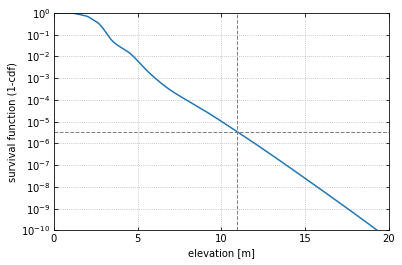

In [9]:
x = np.linspace(0, 20, 1000)

fig, ax = plt.subplots()

# plot survival function
ax.semilogy(x, lte.sf(x))

# format plot
plt.grid(True, which="major", linestyle=":")
ax.tick_params(axis="both", which="major", direction="in")
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both') 
plt.minorticks_off()
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks(1.0*10.0**(-1*np.arange(11)))
ax.set_xlabel("elevation [m]")
ax.set_ylabel("survival function (1-cdf)")
ax.set_xlim([0, x[-1]])
ylim = [1e-10, 1]
ax.set_ylim(ylim)

# 100-year return level
s_t = lte.sf(x_t)
ax.plot([0, x[-1]], [s_t, s_t], '--', color="0.5", linewidth=1)
ax.plot([x_t, x_t], ylim, '--', color="0.5", linewidth=1)
